# Week 09

Unsupervised Learning: Distances and Clustering

## Setup

Run the following 2 cells to import all necessary libraries and helpers for this week's exercises

In [1]:
!wget -q https://github.com/PSAM-5020-2025F-A/5020-utils/raw/main/src/data_utils.py
!wget -q https://github.com/PSAM-5020-2025F-A/5020-utils/raw/main/src/image_utils.py

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import PIL.Image as PImage

from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans

from data_utils import object_from_json_url
from data_utils import balance_score, distance_score, silhouette_score
from data_utils import display_silhouette_plots
from image_utils import get_pixels, make_image

## Cost and Distance Functions

The concept of **_distance_** is something that we saw and used in previous exercises but didn't talk too much about.

**_Distance_** is how we tell how close two data points are to each other, and is the basis for clustering, classification and regression algorithms.

In classification, we learn how to label new data based on how "close" it is to our already-labeled training data. In regression, we find parameters to equations that make our line-of-best-fit "close" to all of the points in the dataset. In clustering, we group data points in a way that minimizes distances between points within a cluster, while maximizing the distances between clusters. Distance is also an important concept for recommendation systems where we want to calculate when someone's taste is close to someone else's.

### 1D

The concept of distance in one dimension is pretty easy to understand: it's how far two points on a line are to each other. Physically, we can think of $1D$ distance as the distance between runners in a race, or, we can even think of time as a one-dimensional space where we measure distance between events in seconds, or minutes, or days.

<img src="./imgs/dist1d.jpg" height="220px" />

Each point in 1-dimensional space is described with a single variable, and the distance between any two points is just the absolute value of their difference:

$\displaystyle D(x_0, x_1) = |x_0 - x_1|$<br>
$\displaystyle D(x_0, x_2) = |x_0 - x_2|$

### 2D

Two-dimensional distances, where we have $2$ variables to describe each of our points, is also pretty familiar to us. This can be the distance between two cities on a map, measured in angles of longitude and latitude, or distances between two points in Manhattan, measured in streets and avenues.

<img src="./imgs/dist2d.jpg" width="95%" />

We have $2$ variables for each of our points and we also have $2$ ways in which we can combine them to measure distances in $2D$. The first is called $L1$, or Manhattan, distance, and it's the sum of the distances in each of the separate dimensions.

$\displaystyle D_{L1}(x_0y_0, x_1y_1) = |x_0 - x_1| + |y_0 - y_1|$

The other way of measuring distances in $2D$ is using the $L2$, or Euclidean, distance formula:

$\displaystyle D_{L2}(x_0y_0, x_2y_2) = \sqrt{(x_0 - x_2)^2 + (y_0 - y_2)^2}$

This is pretty easy to understand as distances on a map, but... what if $x$ is a variable for $height$ in our dataset, and $y$ is the variable for $ear\ length$? The calculations are still valid. As long as we remember to normalize our data, we can use the $L1$ or $L2$ formulas to figure out how "close" our data points are.

### 3D

Three-dimensional points have $3$ variables that describe them, and, while less common, it's still easy to understand how to measure the distance between them. We could be talking about the distance between planets, or between atoms, or between a wifi router and a cellphone. As long as the points aren't on a plane, we need $3$ variables to describe them and measure the distance between them.

<img src="./imgs/dist3d.jpg" width="95%" />

We can extend the $L1$ and $L2$ distance formulas to work in $3D$:

$\displaystyle D_{L1}(x_0y_0z_0, x_1y_1z_1) = |x_0 - x_1| + |y_0 - y_1| + |z_0 - z_1|$

$\displaystyle D_{L2}(x_0y_0z_0, x_2y_2z_2) = \sqrt{(x_0 - x_2)^2 + (y_0 - y_2)^2 + (z_0 - z_2)^2}$

This works even when our $3$ variables aren't actually physical locations. If $x$ is a variable that keeps track of the number of rooms in a house, $y$ a variable for the age of the house, and $z$ the total area of the house, we can use the above formulas to measure how "close" two houses in our dataset are (after we normalize our data, of course).

### N-Dimensions

Most of the datasets we've seen so far already have more then $3$ features/dimensions... what then?

Well... the $L1$ and $L2$ distance formulas can be used regardless of the number of features/dimensions in our dataset. We just keep adding parameters to our formula:

$\displaystyle D_{L1} = \sum_{d}{|A_d - B_d|}$ (for all dimensions $d$)

$\displaystyle D_{L2} = \sqrt{\sum_{d}{(A_d - B_d)^2}}$ (for all dimensions $d$)

So even when we have a dataset with $15$ or $20$ features/dimensions, we can still get some idea of how "close" two points in that dataset are.

### Other Distance Formulas

$L1$ and $L2$ are definitely the most widely used distance formulas in ML applications, but they aren't the only ones. Two other types of distances are:

#### Cosine Similarity

When we're dealing with datasets that are very sparse (there are more dimensions than points), and the $L1$ and $L2$ distances that separate the data points are really huge, we might want to measure the cosine similarity between two points instead.

<img src="./imgs/distcos.jpg" height="300px" />

In the drawing above, instead of measuring the direct distances between $x_0y_0$, $x_1y_1$ and $x_2y_2$, we can pick a separate reference point and measure the cosine of the angles formed by lines drawn from the reference point to each of the other points. We can see that angle $\theta_{12}$ is smaller than $\theta_{01}$ and $\theta_{02}$, which means that $(x_1y_1, x_2y_2)$ is the pair of most similar points.

Points with cosine values close to $1$ are in the same direction in space; points with cosine values close to $0$ are in perpendicular directions, and points with cosine values close to $-1$ are in opposite directions.

$\displaystyle cos(A, B) = \frac{A \cdot B}{ \left|\left|A\right|\right| \left|\left|B\right|\right|}$

$\displaystyle cos(x_0y_0, x_1y_1) = \frac{x_0x_1 + y_0y_1}{\sqrt{x_0^2+y_0^2} \sqrt{x_1^2+y_1^2}}$

#### Mahalanobis Distance

This is useful for measuring distances between points that are part of a collection of points.

<img src="./imgs/distmana-01.jpg" height="250px" />

In the drawing above, if we only had the points $x_0y_0$, $x_1y_1$ and $x_2y_2$, we could use $L2$ distances and everything is fine:

$\displaystyle D_{L2}(x_0y_0, x_1y_1) > D_{L2}(x_0y_0, x_2y_2)$.

But, if instead, $x_0y_0$, $x_1y_1$ and $x_2y_2$ are part of a collection of points with a well-defined average and standard deviation, like the image below, we should use something that makes more common distances shorter, and rarer distances larger.

<img src="./imgs/distmana-02.jpg" height="250px" />

In this case, where $x_0y_0$ and $x_2y_2$ are on the extremes of the distribution, we want the distance between them to be larger than the distance between $x_0y_0$ and $x_1y_1$, which happens along a more common direction of the data.

In order to have $\displaystyle D_{M}(x_0y_0, x_2y_2) > D_{M}(x_0y_0, x_1y_1)$, we have to take into account the distribution of our data: its mean, standard deviation and covariances. One way to do that is using the formula below:

$\displaystyle D_{M}(A, B) = \sqrt{(A - B)^2 V_I}$.

Where $V_I$ is the inverse of the covariance matrix of our points.

## Unsupervised Learning

### Clustering

#### More Wine ! 🍷🍷🍷

Let's pretend we own an online wine store.

Last week we created a model that predicts wine quality based on a bunch of its properties. We could use this model to figure out how much to pay suppliers for the wine, and how much to charge costumers.

But, maybe this "`quality`" feature might not be something we want to share with our costumers. Even though it's based on data, it sounds abstract and subjective and would require explanations about our data and our process, which could create confusion.

Using all features from the original dataset (`alcohol`, `acidity`, `density`, etc) might also not be very useful for costumers who want to buy new wines that are similar to ones that they have previously liked.

What we can do instead is classify the wines into groups that take into account all of the features of the dataset, but present costumers with a more manageable amount of information.

### Recommendations

What we're really hoping to have is a simple recommendation system for our costumers, where we can recommend wines based on previous wines they liked, without them having to know the $10$ features of the previous wines.

There are a few ways of doing this, but the strategy we'll take is called clustering.

### Clustering

[Clustering](https://en.wikipedia.org/wiki/Cluster_analysis), or cluster analysis, is an example of an *unsupervised* learning method that groups items based on their many features and properties.

We'll use it to divide our wines in such a way that wines in the same group, or *cluster*, are more similar to each other than to wines in other clusters.

These clusters won't necessarily correlate directly to the features in our dataset, but will be computed using a combination of the features.

### Supervised Learning

The models that we've trained so far for doing regression and classification are considered *supervised* models. During training we give the model our input features, but also provide it with the *correct* values for the output signals. These output signals tend to be human-labeled values, and are sometimes called the *supervisory signals*.

When fully-labeled training data is processed during training, we are hoping that the model learns to extrapolate what it *sees* in the labeled data to new, unseen, unlabeled instances of data with the same input features, but unknown output values.

#### Supervised Classification:

Given a set of initial data points with labels:<br>
<img src="./imgs/classification-02.jpg" width="620px"/>

We create a model that learns to assign labels to the original points:<br>
<img src="./imgs/classification-03.jpg" width="620px"/>

so that later we can assign correct labels to new data points:<br>
<img src="./imgs/classification-04.jpg" width="620px"/>

### Unsupervised Learning

Unlike supervised learning, unsupervised models learn patterns from unlabeled data. This means all of the features are considered input features, and there are no separate output features or signals. The idea is that by analyzing and processing data in specific ways, the model is able to build a concise representation of its features and create new ways of interpreting, visualizing or generating similar data.

We can use unsupervised learning models to explore new datasets and try to simplify our data before we do any kind of supervised learning.

We can also use supervised learning to build recommendation systems that learn how to group items by their many features or characteristics.

The steps for training an unsupervised model should seem familiar:

1. Load dataset
2. Encode label features as numbers
3. Normalize the data
4. Select variables and features to be considered
5. Create a model
6. Run model on input data and test data
7. Measure error

Even though it all looks familiar, that last step isn't very obvious.

How do we measure error on a model that doesn't have a set of correct answers?

Maybe *error* is not the right term, but we'll see how to define *metrics* to score and measure our unsupervised models.

#### Unsupervised Clusterings:
Since there are no correct labels, both of the following clusterings are valid!

<img src="./imgs/clustering-00.jpg" width="620px"/>

<img src="./imgs/clustering-01.jpg" width="620px"/>

Let's run it !

### Preparing Data

We'll load the same wine dataset as last week and normalize its features:

In [3]:
## 1. Load Dataset
WINE_FILE = "https://raw.githubusercontent.com/PSAM-5020-2025F-A/5020-utils/main/datasets/json/wines.json"

# Read into DataFrame
wines_data = object_from_json_url(WINE_FILE)
wines_df = pd.DataFrame.from_records(wines_data)

# TODO
## 3. Normalize
wine_scaler = StandardScaler().set_output(transform="pandas")
wines_scaled_df = wine_scaler.fit_transform(wines_df)

# TODO
## 4. Select variables to be considered
##    We should drop the quality features to avoid re-clustering by quality
features = wines_scaled_df.drop(columns=["quality"])

### Clusterings

Let's look at our first clustering algorithm:

#### [K-means Clustering](https://scikit-learn.org/stable/modules/clustering.html#k-means):
Tries to separate the data into $k$ groups with similar properties. Requires the number of clusters to be determined beforehand, and the algorithm tries to minimize the difference between objects in a cluster.

Let's cluster our data into $7$ groups.

In [4]:
n_clusters = 7

## 5. Create Clustering object
km_model = KMeans(n_clusters=n_clusters, random_state=1010)

## 6. Run the model on the data
km_predicted = km_model.fit_predict(features)

In [5]:
km_predicted

array([2, 2, 4, ..., 5, 5, 5], shape=(4701,), dtype=int32)

In [12]:
# TODO: explore km_model
print("| KMeans Model Exploration |")
print(f"Number of clusters: {n_clusters}")
print(f"Inertia: {km_model.inertia_:.2f}")
print(f"Number of iterations: {km_model.n_iter_}")
print(f"First 10 cluster labels: {km_model.labels_[:10]}")
len(km_model.cluster_centers_[0]), km_model.cluster_centers_[0]



| KMeans Model Exploration |
Number of clusters: 7
Inertia: 25943.02
Number of iterations: 36
First 10 cluster labels: [2 2 4 3 4 0 6 4 4 4]


(10,
 array([-0.22361752,  1.63339937, -1.07191358, -0.11799797,  0.20526626,
         0.0261512 ,  0.15251498, -0.00181806, -0.24208769, -0.52141135]))

### Plots

Let's pick $2$ or $3$ variables to visualize our data and clusters.

This could be any of our features, but let's look at the *covariances* table and pick features related to the highest covariance magnitudes.

In [13]:
## Look at covariances of features
features.cov()

,acidity,volatility,citrics,sugar,chlorides,sulfur dioxide,density,pH,sulphates,alcohol
acidity,1.000213,-0.024894,0.288788,0.088961,0.020307,0.087274,0.264749,-0.426246,-0.017419,-0.120791
volatility,-0.024894,1.000213,-0.148188,0.064996,0.060739,0.086940,0.025255,-0.031073,-0.034555,0.072120
citrics,0.288788,-0.148188,1.000213,0.097869,0.118972,0.117626,0.153235,-0.165176,0.055348,-0.081787
sugar,0.088961,0.064996,0.097869,1.000213,0.086966,0.401167,0.839773,-0.191525,-0.023870,-0.449726
chlorides,0.020307,0.060739,0.118972,0.086966,1.000213,0.196679,0.257748,-0.089664,0.013027,-0.365664
sulfur dioxide,0.087274,0.086940,0.117626,0.401167,0.196679,1.000213,0.529282,0.007757,0.134656,-0.449696
density,0.264749,0.025255,0.153235,0.839773,0.257748,0.529282,1.000213,-0.092851,0.077258,-0.778734
pH,-0.426246,-0.031073,-0.165176,-0.191525,-0.089664,0.007757,-0.092851,1.000213,0.158027,0.123947
sulphates,-0.017419,-0.034555,0.055348,-0.023870,0.013027,0.134656,0.077258,0.158027,1.000213,-0.020609
alcohol,-0.120791,0.072120,-0.081787,-0.449726,-0.365664,-0.449696,-0.778734,0.123947,-0.020609,1.000213


In [14]:
## TODO: look at max absolute value per column
features_cov = features.cov()

for i in range(len(features_cov)):
  features_cov.iloc[i,i] = 0

display(features_cov.abs().max())
display(features_cov.abs().idxmax())

acidity           0.426246
volatility        0.148188
citrics           0.288788
sugar             0.839773
chlorides         0.365664
sulfur dioxide    0.529282
density           0.839773
pH                0.426246
sulphates         0.158027
alcohol           0.778734
dtype: float64

acidity                pH
volatility        citrics
citrics           acidity
sugar             density
chlorides         alcohol
sulfur dioxide    density
density             sugar
pH                acidity
sulphates              pH
alcohol           density
dtype: object

The highest pairs are `density`/`sugar` and `alcohol`/`density`.

We should visualize our clusters as a function of `density`, `sugar` and `alcohol`.

Let's define a reusable function to help us with the plotting:

In [15]:
def plot_clusters(features, labels, clusters, title):
  xl, yl, zl = labels[:3]
  x = features[xl]
  y = features[yl]
  z = features[zl]

  # 2D
  plt.scatter(x, y, c=clusters, marker='o', linestyle='', alpha=0.5)
  plt.title(f"{title} clustering")
  plt.xlabel(xl)
  plt.ylabel(yl)
  plt.ylim([-2.2, 3])
  plt.show()

  plt.scatter(x, z, c=clusters, marker='o', linestyle='', alpha=0.5)
  plt.title(f"{title} clustering")
  plt.xlabel(xl)
  plt.ylabel(zl)
  plt.ylim([-2.2, 3])
  plt.show()

  # 3D
  fig = plt.figure(figsize=(8, 8))
  ax = fig.add_subplot(projection='3d')

  ax.scatter(x, y, z, c=clusters, marker='o', linestyle='', alpha=0.5)

  ax.set_title(f"{title} clustering")
  ax.set_xlabel(xl)
  ax.set_ylabel(yl)
  ax.set_zlabel(zl)
  ax.set_ylim(-2.5, 8)
  ax.set_zlim(-2.5, 2.5)

  plt.show()

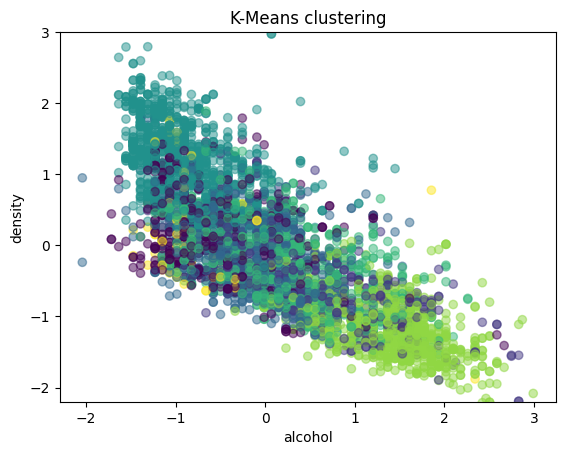

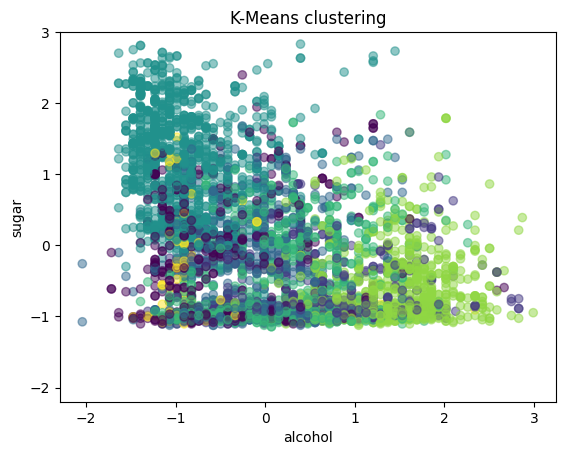

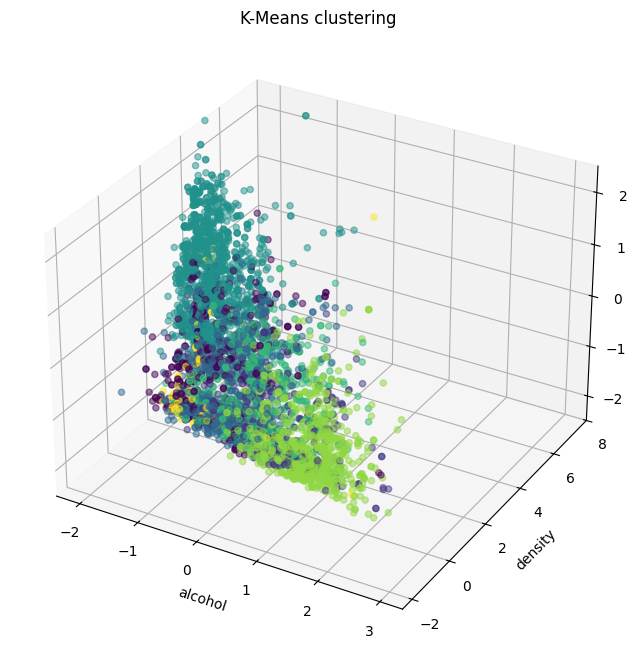

In [16]:
# For plotting
labels = ["alcohol", "density", "sugar"]
clusters = km_predicted

plot_clusters(features, labels, clusters, "K-Means")

In [17]:
## TODO: look at min absolute value per column
features_cov = features.cov()

# for i in range(len(features_cov)):
  # features_cov.iloc[i,i] = 0

display(features_cov.abs().min())
display(features_cov.abs().idxmin())

acidity           0.017419
volatility        0.024894
citrics           0.055348
sugar             0.023870
chlorides         0.013027
sulfur dioxide    0.007757
density           0.025255
pH                0.007757
sulphates         0.013027
alcohol           0.020609
dtype: float64

acidity                sulphates
volatility               acidity
citrics                sulphates
sugar                  sulphates
chlorides              sulphates
sulfur dioxide                pH
density               volatility
pH                sulfur dioxide
sulphates              chlorides
alcohol                sulphates
dtype: object

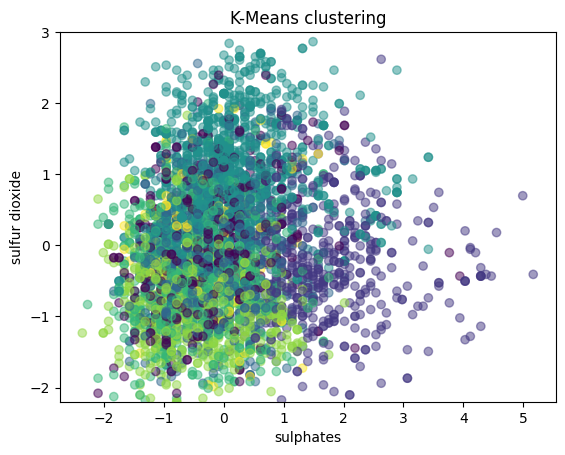

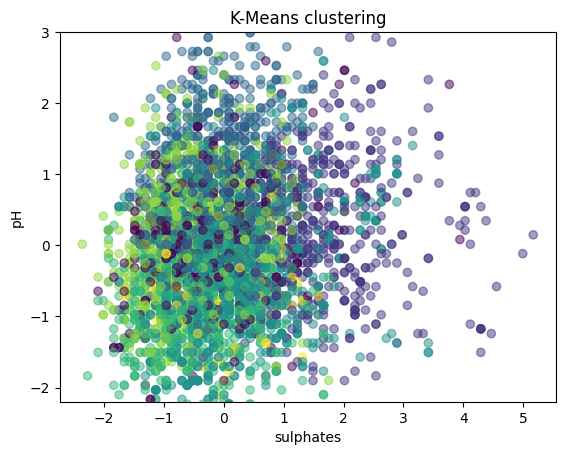

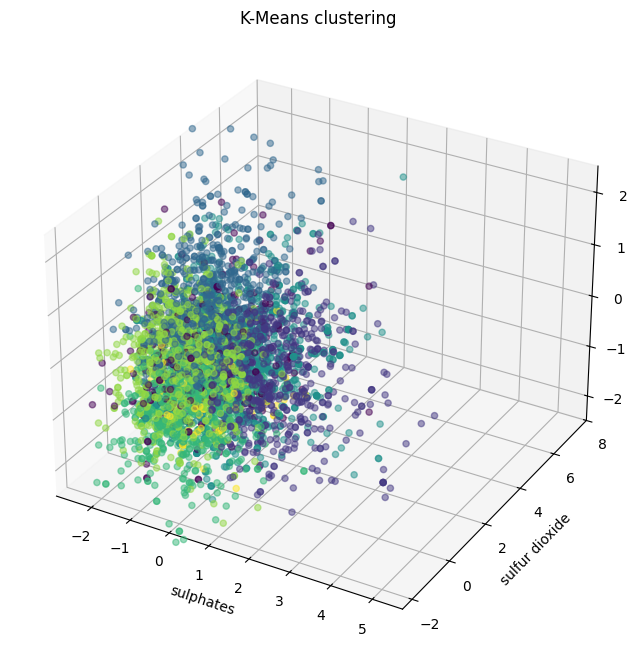

In [18]:
# For plotting
labels = ["sulphates", "sulfur dioxide", "pH"]
clusters = km_predicted

plot_clusters(features, labels, clusters, "K-Means")

## Number of clusters

Does the number of clusters affect clustering ?

Change the variable and re-run clustering to see how the groupings change.

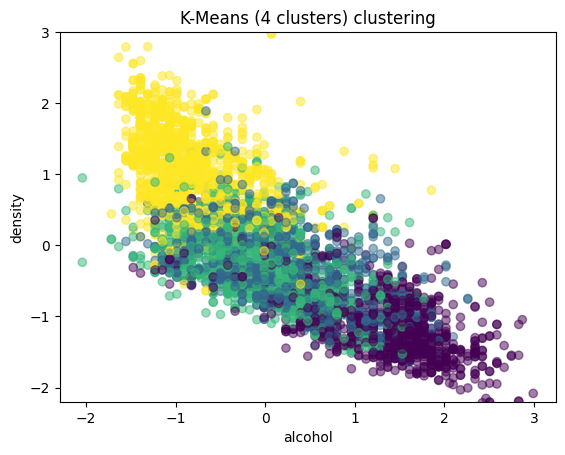

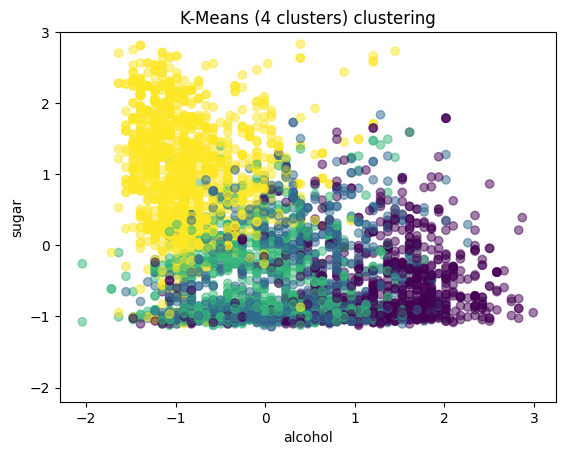

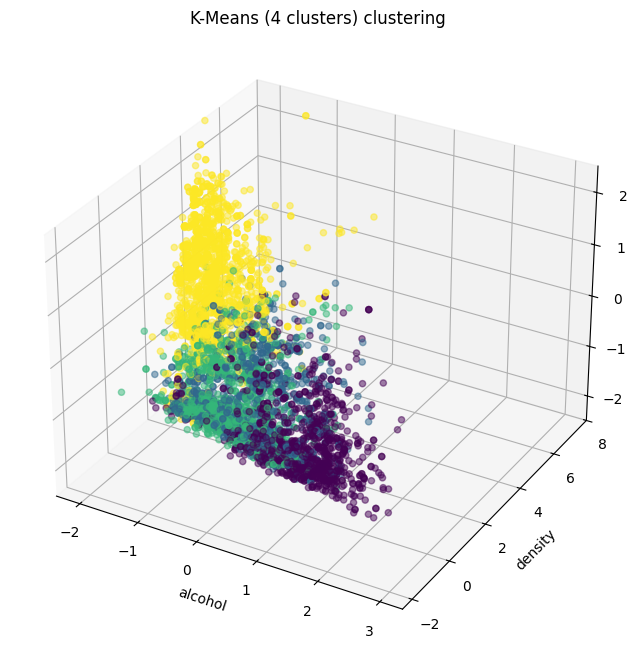

In [23]:
# Change number of clusters
n_clusters = 4

# Re-run clustering
km_model = KMeans(n_clusters=n_clusters, random_state=1010)
km_predicted = km_model.fit_predict(features)

# 
# Re-plot or explore results
plot_clusters(features, ["alcohol", "density", "sugar"], km_predicted, f"K-Means ({n_clusters} clusters)")

### Interpretation

What changes ? Does one choice seem better than the others ?

Once the number of clusters was changed to 4, the model was able to group the data intro broader, more specific regions. 
Compared to 7 clusters, these 4 clusters are larger and more cohesive, showing separations along the alcohol density & alcohol suuar dimensions. 

From the plots:
Alcohol and density remain strongly inversely related, as alcohol increases, density decreases.
Having 4 clusters made tthe transitions between groups smoother, in contrast to having 7 clusters which had data separated into alot of smaller, overlapping regions.

In conclusion, Choosing 4 clusters made it easier to interpret and simplified the general structure.

### Other Clustering Options

There are many algorithms for clustering data, that differ in the assumptions they make about the data, and which parameters should be optimized.

There's one method called [Gaussian Clustering](https://scikit-learn.org/stable/modules/mixture.html#mixture) that is similar to K-means, but it assumes that all features of our data can be modeled as [Gaussian distributions](https://en.wikipedia.org/wiki/Normal_distribution). During clustering, the algorithm incorporates information about the covariance structure of the data to try to determine mean and standard deviation values for each cluster.

[Scikit-Learn](https://scikit-learn.org/) has implementation for this algorithm, and many more. It's called `GaussianClustering` and its constructor take the same parameters as the `KMeansClustering` constructor.

Repeat steps $5$ and $6$ to create a model using `GaussianClustering` and run it on our data.

In [24]:
n_clusters = 4

## TODO: 5. Create Clustering object
gc_model = GaussianMixture(n_components=n_clusters, random_state=101010)

## TODO: 6. Run the model on the data
gc_predicted = gc_model.fit_predict(features)

In [25]:
gc_predicted

array([3, 2, 0, ..., 3, 3, 0], shape=(4701,))

### Plot results

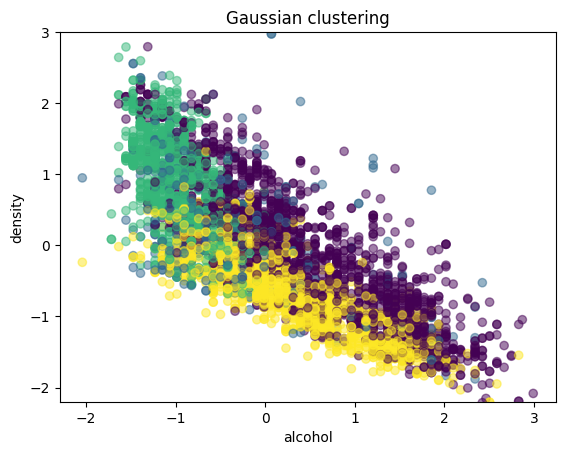

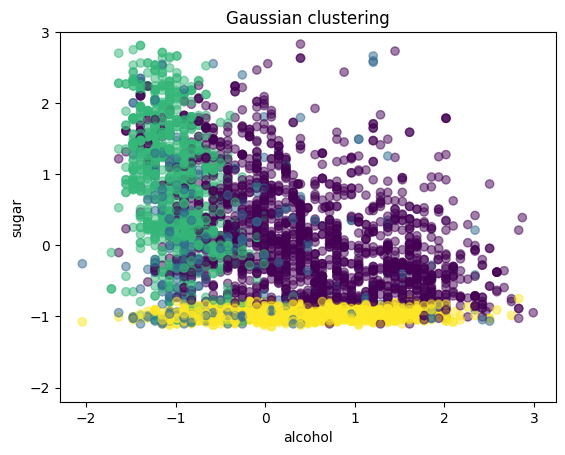

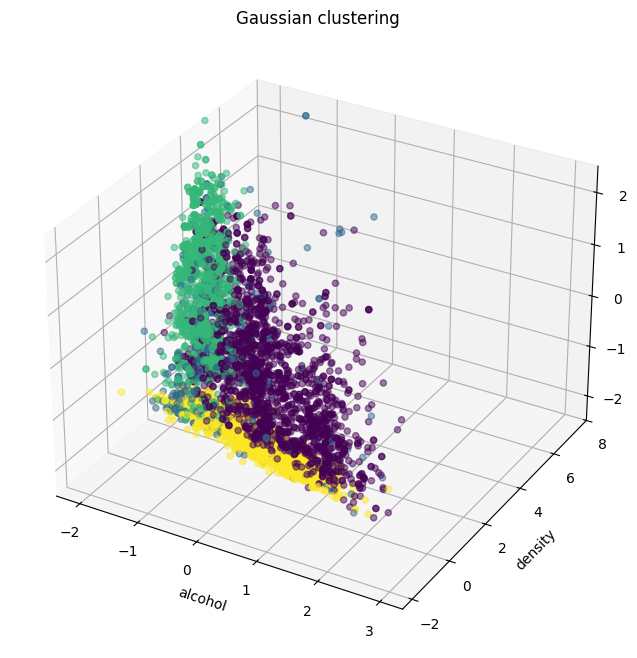

In [26]:
# Plots for Gaussian Clustering results
labels = ["alcohol", "density", "sugar"]
clusters = gc_predicted

plot_clusters(features, labels, clusters, "Gaussian")

### Interpretation

Are the results any different than k-mean clustering ?

The relationships between variables remain similar to K-means clustering. The overall cluster patterns and group separations haven’t changed much, though Gaussian clustering produces smoother boundaries.

### Scoring

Would be nice to have a way to measure how good these clusters actually are.

It would help determine if we need more clusters, or if one method is actually better than the other.

There are a couple of ways to do this.

### Model-Specific Scores

These are the scoring functions associated with each of the models we're using. They're called by passing the input features to `score()`.

#### K-Means score

This returns the sum of squared distances between each point and its cluster's center. It's the sum of the euclidean distances without the square root.

In order to maintain the convention that higher scores indicate a better model, this returns the negative value of the distance sums.

#### Gaussian Likelihood score

The Gaussian model `score()` function computes the per-sample average log-likelihood of each point in the dataset.

The log-likelihood score is a statistical measurement of how well the model fits our data.

Log-likelihood scores can range from negative infinity to positive infinity, where higher scores indicate a better model.

### Note

Although somewhat related, these `distance` and `likelihood` calculations measure different things, and are in different units.

We can't compare distances to likelihoods to draw any kind of conclusion.

Moreover, the actual values of these `score()` functions are not usually meaningful on their own. They should be used to compare different models created with different values for parameters like the number of clusters.

In [27]:
print("KMeans objective score:", km_model.score(features))
print("Gaussian likelihood score:", gc_model.score(features))

KMeans objective score: -31638.669336788338
Gaussian likelihood score: -10.100344340055091


### Distance Score

The first kind of scoring uses the average of the distances between each point and its cluster's center as a metric.

Each cluster's center is represented by the average values of all of the features of all of its members. We can use the L2-distance we saw above to calculate and accumulate the distances from each point to its cluster's center.

Luckily, our clustering models have a `distance_score()` function that can be used to report the average distance amongst members of a cluster, after `fit()` has been called.

A smaller cluster distance means that the cluster center is a good representation of its members.

Both the K-Means and Gaussian clustering objects have this function.

In [28]:
print("KMeans distance score:", distance_score(features, km_predicted))
print("Gaussian distance score:", distance_score(features, gc_predicted))

KMeans distance score: 2.3665706001712725
Gaussian distance score: 2.9288231190066867


### Balance Score

A final metric we can consider when analyzing different clustering algorithms and strategies is to see how balanced the resulting clusters are. This isn't always important; we might have categories of items or events that are more common than others, and will produce unequal cluster groups.

In other cases, where we know we want to have groups of similar sizes, this is a good metric to look at. For example, if we were to use the body measurement dataset for deciding how many sizes of bike helmets to produce, we should probably have sizes that cover similar portions of the population, and avoid very bespoke sizes that only fit few people.

We compute _balance score_ by summing the differences between our cluster sizes and the sizes of a perfectly balanced clustering. Once we have this sum, we scale it to get a number between $0$, for a perfectly balanced clustering, and $1$, for a most-unbalanced clustering.

$\displaystyle balance\ score = 1.0 - \frac{1}{2} \left(\frac{n}{n-1}\right) \sum_{i=1}^{n}{\left|\frac{C_i}{C_0 + C_1 + ... + C_n} - \frac{1}{n}\right|}$

The $\frac{C_i}{C_0 + C_1 + ... + C_n}$ terms are the sizes of our $n$ clusters expressed as the percentage of the total number of items in all clusters. The $\frac{1}{n}$ term is the size of each cluster in a perfectly balanced clustering. We sum up these differences and scale it all by $\frac{1}{2} \left(\frac{n}{n-1}\right)$ to get a number between $0$ and $1$.

We don't have to focus too much on this math right now. It's here for completeness and because it's good to practice reading an algorithm described as text, math equations and code.

Luckily this has also been implemented for us and we can get our model's _balance score_ by calling the `balance_score()` function of our clustering object.

A _balance score_ of $1$ means all of the clusters are perfectly balanced, while a score of $0$ means the clusters are at their most unbalanced.

In [29]:
print("KMeans balance score:", balance_score(km_predicted))
print("Gaussian balance score:", balance_score(gc_predicted))

KMeans balance score: 0.8880380060979933
Gaussian balance score: 0.7621782599446927


### Silhouette Score

This measures the separation distance between our clusters by computing two internal metrics for each point in our data: cohesion and separation.

<img src="./imgs/silhouette-00.jpg" height="400px"/>

Cohesion measures the similarity of points within the same cluster. It's calculated by measuring the average distance between a point and every other point in its cluster.

Separation measures how much our clusters don't overlap and is sort of the complement to cohesion. It's calculated by finding the smallest cohesion between a point and all other clusters.

The Silhouette Score for a point is then:
$$s_i = \frac{Separation(x_i) - Cohesion(x_i)}{max(Cohesion(x_i), Separation(x_i))}$$

It scores each point on a scale of $[-1, 1]$, where $-1$ indicates the point could belong to a different cluster and $1$ indicates a point is well clustered.

The `silhouette_score()` function of our clustering objects will give us the average silhouette score of all points in the clustered dataset.

Along with `distance_score()` we can use `silhouette_score()` to pick parameters to our clustering models, but also to help us pick the model type (KMeans vs Gaussian).

In [30]:
print("KMeans silhouette score:", silhouette_score(features, km_predicted))
print("Gaussian silhouette score:", silhouette_score(features, gc_predicted))

KMeans silhouette score: 0.14006652955710383
Gaussian silhouette score: 0.06022482190751317


### Silhouette Plots

We can plot Silhouette scores for all of our points and see if we have clusters that are entirely below the average silhouette score, or clusters with wide variation of silhouette scores. It gives us a visual and compact way to analyze our clustering, even including information about cluster balance.

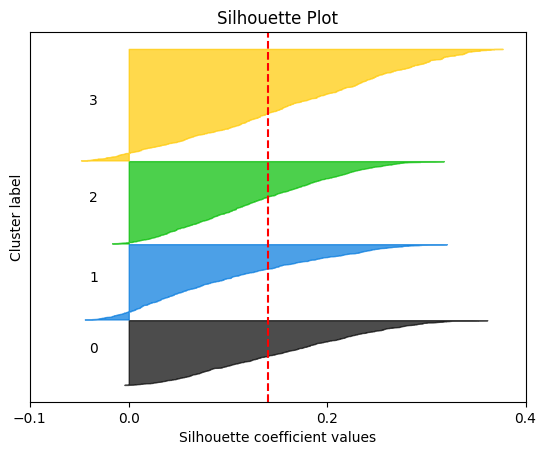

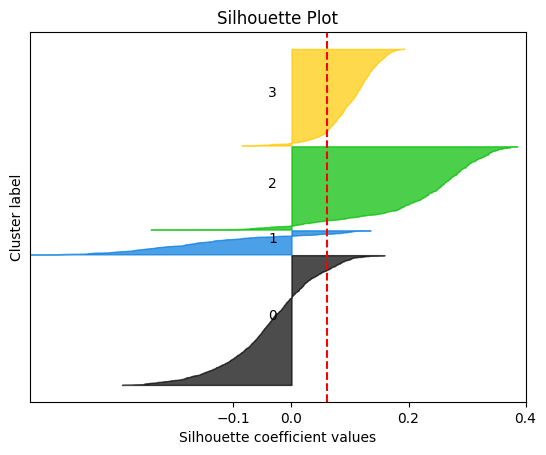

In [31]:
display_silhouette_plots(features, km_predicted)
display_silhouette_plots(features, gc_predicted)

### Number of clusters

If we consider the distance and balance metrics for the $2$ algorithms, it seems like `KMeansClustering` produces more coherent and balanced clusters. This suggests that our features might not be normally distributed, or, our data is not a combination of gaussian features.

Let's try different cluster numbers for the K-Means algorithm to see if there's a *better* way of clustering our wines:

In [ ]:
# try 2 - 10 clusters for K-Means Clustering
num_clusters = list(range(2,10))

# collect distance, silhouette and balance scores
score_scores = []
distance_scores = []
silhouette_scores = []
balance_scores = []

# get distance, likelihood and balance for different clustering sizes
for n in num_clusters:
  mm = KMeans(n_clusters=n)
  pred = mm.fit_predict(features)
  score_scores.append(mm.score(features))
  distance_scores.append(distance_score(features, pred))
  silhouette_scores.append(silhouette_score(features, pred))
  balance_scores.append(balance_score(pred))

# plot scores as function of number of clusters
plt.plot(num_clusters, score_scores, marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("Distance Squared Sum Score")
plt.title("K-means Clustering")
# plt.ylim([0, 3])
plt.show()

plt.plot(num_clusters, distance_scores, marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("Distance Score")
plt.title("K-means Clustering")
# plt.ylim([0, 3])
plt.show()

plt.plot(num_clusters, silhouette_scores, marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.title("K-means Clustering")
# plt.ylim([-1, 1])
plt.show()

plt.plot(num_clusters, balance_scores, marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("Balance Score")
plt.title("K-means Clustering")
plt.ylim([0, 1])
plt.show()

### Interpretation

Doesn't seem like the number of clusters affects the scores for `KMeansClustering` too much.

Let's re-cluster into $2$ clusters, just to see what that looks like:

In [ ]:
# Cluster
n = 3
m_model = KMeans(n_clusters=n)
km_predicted = m_model.fit_predict(features)

# Plot
labels = ["alcohol", "pH", "sugar"]
clusters = km_predicted

plot_clusters(features, labels, clusters, "K-Mean")

display_silhouette_plots(features, km_predicted)

### Analysis

So, even though a higher number of clusters gives us slightly better distance score values, some of the clusters are really small and hard to find on the graphs.

If this clustering is to be used for recommending wines to costumers, maybe using $2$ or $3$ clusters is a more sensible way of grouping our wines because the subtleties between $5$ categories of wine might be less easy to explain.

Using $2$ or $3$ categories is probably more legible. The categories could be something like: `bold` and `sweet`.

## Images

Clustering can also be used to help analyze image and audio files.

We can extract color information from an image by clustering its pixels by their RGB values. This can be used to get an estimate of the most "important" colors in an image. They're not the most common colors, necessarily, but the colors necessary to represent the image.

This is called `color quantization` and is a kind of compression because we reduce the total number of colors in an image from a possible $16\text{,}581\text{,}375$ unique colors to $4$, $8$, $16$, etc... colors while preserving the overall appearance of the image. The calculated cluster centers become the color palette of the image, and we can re-color the image using only those colors.

We start by loading an image:

In [ ]:
mimg = PImage.open("./data/image/flowers.jpg")

display(mimg)

### Colors as features

Since this process works on the pixels of a single image, we can think of each pixel as a measurement and its `R`, `G` and `B` values as its features.

Before we put our image through clustering we should turn it into a `DataFrame` where the rows are the pixels and the columns are the `R`, `G`, `B` values.

We can use the `pd.DataFrame.from_records()` function, but first we have to turn our pixel list into a list of objects:

`[ [R,G,B], [R,G,B], [R,G,B], ... ]` -> `[{"R": R, "G": G, "B": B}, {"R": R, "G": G, "B": B}, ...]`

In [ ]:
mimg.size

In [ ]:
# Create list of objects from list of lists
pixelObj = [{"R":r, "G":g, "B":b} for r,g,b in get_pixels(mimg)]

img_df = pd.DataFrame.from_records(pixelObj)
img_df

### Encoding/Scaling

Not needed! All our features are already numbers, and they're all in the same units.

### Plot

We just opened a new "dataset"... let's plot it.

Since our features are the `R`, `G` and `B` channel values for each pixel, we can actually plot these in $3D$.

Each of the features will place a point in `x`, `y`, `z` space, and the color of the point can be the color of the pixel.

The only funny business here is that `pyplot` expects colors in the range $[0, 1]$ and not $[0, 255]$, so we have to convert those.

We could use a `MinMaxScaler`, but since the inputs are already in a known range and the math is easy, we'll just use a comprehension.

In [ ]:
# convert [0, 255] to [0, 1]
c = [(r/255, g/255, b/255) for r,g,b in get_pixels(mimg)]

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection='3d')

ax.scatter(img_df["R"], img_df["G"], img_df["B"], c=c, marker='o', linestyle='', alpha=0.5)
ax.set_xlabel("R")
ax.set_ylabel("G")
ax.set_zlabel("B")
plt.show()

### Repeat

Repeat the above process for a different image in the `./data/image` directory, or something else.

In [ ]:
# TODO: Visualize pixel color distributions for other images

### Cluster !

Set up the `Clustering` object and run `fit_predtict()`.

In [ ]:
n_clusters=8

## Create Clustering object
km_model = KMeans(n_clusters=n_clusters)

## Run the model on the pixel data
km_predicted = km_model.fit_predict(img_df)

km_predicted

### Un-Cluster / Group

The `km_predicted` variable holds a `DataFrame` that is a mapping from pixel index to cluster index, but what we really want is to re-map our original pixels into the color palette made up of our cluster centers.

The `KMeansClustering` object has a member variable called `cluster_centers_` that holds the centers of our clusters. We can use this to build a new pixel array for our image.

Let's take a look at the cluster centers:

In [ ]:
km_model.cluster_centers_

We have $8$ lists inside the `cluster_centers_` list. They should represent colors, but they're using floating point numbers right now, which will most likely give us troubles when we try to turn these into an image.

Let's transform these into `int`s:

In [ ]:
# using round() or int() to ensure our cluster centers are valid color values (ints)
color_centers = [[round(r), round(g), round(b)] for r,g,b in km_model.cluster_centers_]

print(color_centers)

Now we can use these in a pixel array.

Let's iterate through the `km_predicted["clusters"]` and use those values to push their corresponding cluster center colors into a new pixel array.

We go through `km_predicted["clusters"]`, and if we see cluster $0$ we want to push `color_centers[0]` onto our pixel array, etc...

In [ ]:
clustered_pxs = []

# Iterate through the cluster list and append the right color for each pixel
for gidx in km_predicted:
  clustered_pxs.append(color_centers[gidx])

display(make_image(clustered_pxs, mimg.size[0]))